In [32]:
import sys
sys.path.append('/home/fenglab/Desktop/transdiff_GRN/src/')
from glob import glob
from matplotlib.collections import PatchCollection

from find_modules import *
from topology import *

In [33]:
treatments = ['Anp', 'AMn', 'AMp', 'AMnp']
colors = {'Anp':'#0088ff', 'AMn':'#ff6f00', 'AMp':'#00e883', 'AMnp':'#ffbf00'}
gene_anp = ['OTX2', 'CEBPA', 'TCF3']#, 'ISL1', 'PRDM1', 'PRRX1']
gene_amn = ['HEY1', 'MLXIPL', 'HEYL']#, 'KLF6', 'ST18', 'LMX1A']
gene_amp = ['DLX3', 'NR1D1', 'ZNF395']#, 'ZHX1', 'ZNF510', 'ARNT']
gene_amnp = ['LMX1A', 'PRDM1', 'ISL1']#, 'KLF7', 'ETV5']

In [34]:
def scatter_rank_for_gene(df, gene, var_x, var_y, runs=10, roll=10):
    '''scatter plot of global gene rank quantile with rolling standard deviation'''
    df = df[df['geneid']==gene].sort_values(by='nodes')
    x = df[var_x].rolling(roll).mean()
    y = (df[var_y]/df[var_x]).rolling(roll).mean()
    stdy = (df[var_y]/df[var_x]).rolling(roll).std(ddof=runs-1)
    plt.scatter(df[var_x], df[var_y]*100/df[var_x], s=1, alpha=0.5, color='tab:blue')
    plt.fill_between(x, (y-stdy)*100, (y+stdy)*100, alpha=0.1, color='tab:blue')
    plt.ylim(bottom=0, top=100)
    plt.xlim(left=0, right=800)
    plt.ylabel(gene+'\nRank Quantile', fontsize=17)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.invert_yaxis()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

In [35]:
def gene_go_summary(df_file, files, treatment, gene):
    '''collapse clusterProfiler outputs of communities containing the designated gene 
    into one dataframe and calculate the summary stats for each gene ontology term'''
    dflist=[]
    df_gene_file = df_file[df_file['geneid']==gene]
    lgf = [f'./../results/GO/{treatment}_{str(a)}_{str(b)}_{str(c)}.csv' \
        for (a,b,c) in zip(df_gene_file['run'], df_gene_file['nodes'], df_gene_file['community'])]

    for file in list(set(files)&set(lgf)):
        dfannots = pd.read_csv(file)
        dfannots['refgs'] = [int(n.split('/')[0]) for n in dfannots['BgRatio']]
        dfannots = dfannots[(dfannots['refgs']<1500)&(dfannots['refgs']>10)]
        dfannots = dfannots.drop_duplicates(subset='geneID', keep='first')
        dflist.append(dfannots[['Description', 'p.adjust', 'refgs']])
    dfgl = pd.concat(dflist)

    dfgo = dfgl.groupby('Description').count()[['p.adjust']].rename(columns={'p.adjust':'counts'})
    dfgo['median'] = dfgl.groupby('Description').median()['p.adjust']
    dfgo['refgs'] = dfgl.groupby('Description').median()['refgs']
    dfgo['lq'] = dfgl.groupby('Description').quantile(0.75)['p.adjust']
    dfgo['rq'] = dfgl.groupby('Description').quantile(0.25)['p.adjust']
    dfgo['min'] = dfgl.groupby('Description').min()['p.adjust']
    dfgo['max'] = dfgl.groupby('Description').max()['p.adjust']
    return dfgo

def go_plot(dfgo, grn_number, number=10, count_legend=False, cbarn=False, label_right=False):
    '''bar plot of gene ontologies for communities containing the designated gene'''
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    mpl.rcParams.update({'font.size': 15})
    
    dfgo = dfgo.sort_values(by=['counts'], ascending=True)[-number:]
    dfgo = dfgo.sort_values(by=['median'], ascending=False)
        
    y = np.arange(number)
    x = -np.log10(dfgo['median'].to_numpy())
    c = np.log2(dfgo['refgs'].to_numpy())
    R = (dfgo['counts'].to_numpy())/(grn_number*2)
    
    lq = -np.log10(dfgo['lq'].to_numpy())
    rq = -np.log10(dfgo['rq'].to_numpy())
    lm = -np.log10(dfgo['max'].to_numpy())#lq-1.5*(rq-lq)
    rm = -np.log10(dfgo['min'].to_numpy())#rq+1.5*(rq-lq)
    ylabels = list(dfgo.index)
    ylabels = [yl.replace('projection', 'proj.') for yl in ylabels]
    ylabels = [yl.replace('regulation', 'reg.') for yl in ylabels]
    ylabels = [yl.replace('differentiation', 'differ.') for yl in ylabels]
    ylabels = [yl.replace('organization', 'org.') for yl in ylabels]
    ylabels = [yl.replace('morphogenesis', 'morpho.') for yl in ylabels]
    ylabels = [yl.replace('development', 'devel.') for yl in ylabels]
    xlabels = list(np.arange(1,9))

    midl = [plt.Rectangle((j,i-r), width=0.08, height=2*r) for r, j, i in zip(R, x, y)]
    recs = [plt.Rectangle((jl,i-r), width=jr-jl, height=2*r) for r, jl,jr, i in zip(R, lq, rq, y)]
    lines = [plt.Rectangle((jl,i-0.02), width=jr-jl, height=0.04) for jl,jr, i in zip(lm, rm, y)]
    if count_legend:
        legend = [plt.Rectangle((5.5,2.5), width=1, height=1), # 100%
                plt.Rectangle((5.5,1.4), width=1, height=0.5), # 50%
                plt.Rectangle((5.5,0.5), width=1, height=0.25)] # 25%
        col = PatchCollection(lines+recs+midl+legend, array=np.array(list(c)*2+[0]*len(c)+[20]*3), cmap='YlGnBu')
    else:
        col = PatchCollection(lines+recs+midl, array=np.array(list(c)*2+[0]*len(c)), cmap='YlGnBu')
    ax.add_collection(col)
    col.set_clim([2, 11])

    ax.set(xticks=np.arange(1,9), yticks=np.arange(len(ylabels)),
           yticklabels=ylabels)
    ax.set_xticklabels(labels=xlabels)
    ax.set_xticks(np.arange(1,9)-0.5, minor=True)
    ax.set_yticks(np.arange(number+1)-0.5, minor=True)
    #ax.grid(which='minor', visible=True, linewidth=1.5, linestyle=':')

    ax.tick_params(axis=u'y', which=u'both',length=0)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    #ax.spines['left'].set_color('none')
    if label_right:
        ax.yaxis.set_label_position('right')
        ax.yaxis.tick_right()

    if cbarn:
        cbar = fig.colorbar(col, shrink=0.6, ticks=np.arange(3,11), label='log'+r'$_{2}$'+'(Ref size)')
        cbar.ax.set_yticklabels(list(np.arange(3,11)))


In [36]:
go_files = glob(f'./../results/GO/*')

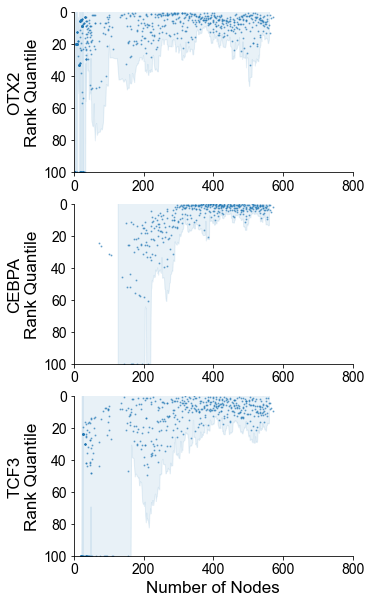

In [37]:
df = pd.read_csv(f'./../results/rank_gene_{treatments[0]}.txt', sep='\t')
var_x = 'nodes'
var_y = 'rank_betweenness'
fig = plt.figure(figsize=(5, 10))
genelist = gene_anp
for n, gene in enumerate(genelist):
    ax = fig.add_subplot(len(genelist),1,n+1)
    scatter_rank_for_gene(df, gene, var_x, var_y)
plt.xlabel('Number of Nodes', fontsize=17);
plt.savefig('./../figs/S4A1.svg', pad_inches=0.1, bbox_inches='tight')

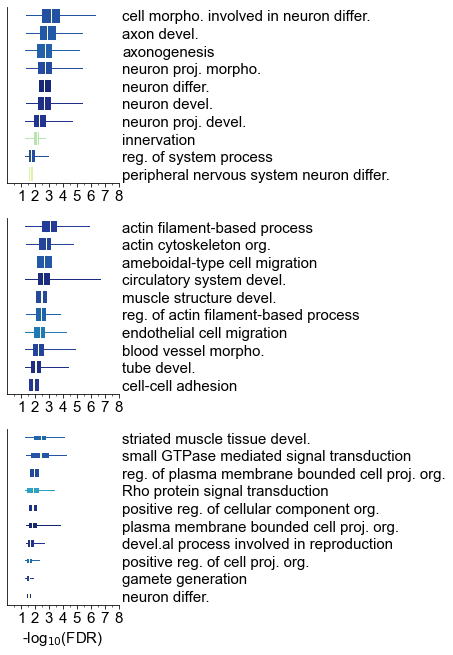

In [38]:
df_tfs = pd.read_csv(f'./../results/rank_community_{treatments[0]}.txt', sep='\t')
grn_number = len(df.drop_duplicates(subset=['run', 'nodes']))
fig = plt.figure(figsize=(2, 11))
for n, gene in enumerate(genelist):
    ax = fig.add_subplot(len(genelist),1,n+1)
    go_plot(gene_go_summary(df_tfs, go_files, treatments[0], gene), grn_number=grn_number, label_right=True)
plt.xlabel('-log'+r'$_{10}$'+'(FDR)');
plt.savefig('./../figs/S4A2.svg', pad_inches=0.1, bbox_inches='tight')

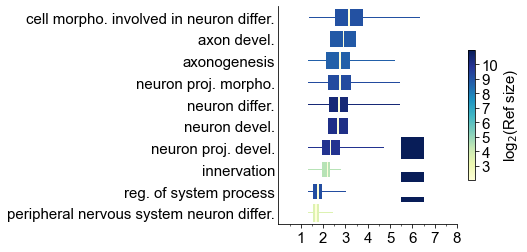

In [39]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1,1,1)
grns = len(df.drop_duplicates(subset=['run', 'nodes']))
go_plot(gene_go_summary(df_tfs, go_files, treatments[0], 'OTX2'), 
        grn_number=grns, count_legend=True, cbarn=True)
plt.savefig('./../figs/S4A3.svg', pad_inches=0.1, bbox_inches='tight')

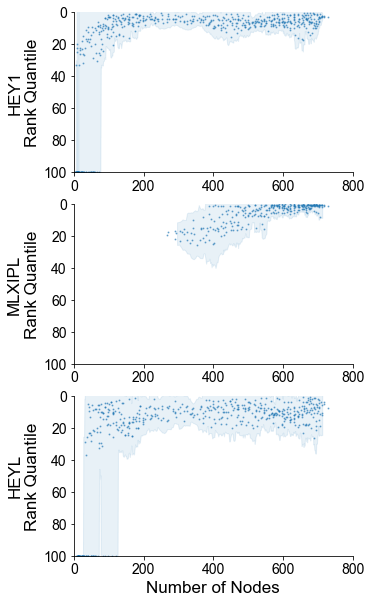

In [40]:
df = pd.read_csv(f'./../results/rank_gene_{treatments[1]}.txt', sep='\t')
var_x='nodes'
var_y = 'rank_betweenness'
fig = plt.figure(figsize=(5, 10))
genelist = gene_amn
for n, gene in enumerate(genelist):
    ax = fig.add_subplot(len(genelist),1,n+1)
    scatter_rank_for_gene(df, gene, var_x, var_y)
plt.xlabel('Number of Nodes', fontsize=17);
plt.savefig('./../figs/S4B1.svg', pad_inches=0.1, bbox_inches='tight')

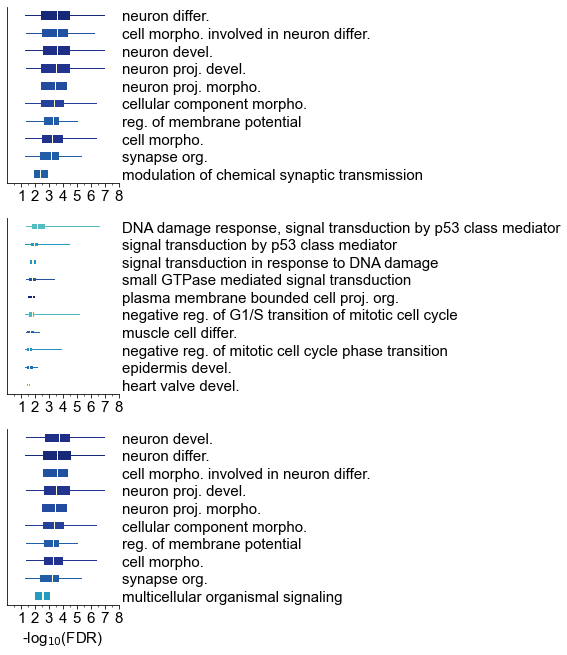

In [41]:
df_tfs = pd.read_csv(f'./../results/rank_community_{treatments[1]}.txt', sep='\t')
grn_number = len(df.drop_duplicates(subset=['run', 'nodes']))
fig = plt.figure(figsize=(2, 11))
for n, gene in enumerate(genelist):
    ax = fig.add_subplot(len(genelist),1,n+1)
    go_plot(gene_go_summary(df_tfs, go_files, treatments[1], gene), grn_number=grn_number, label_right=True)
plt.xlabel('-log'+r'$_{10}$'+'(FDR)');
plt.savefig('./../figs/S4B2.svg', pad_inches=0.1, bbox_inches='tight')

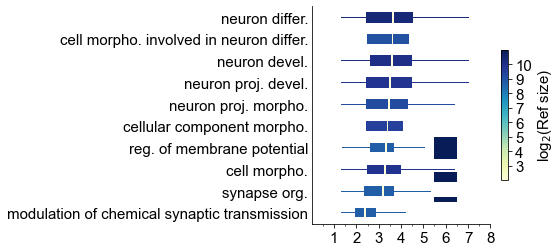

In [42]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1,1,1)
grns = len(df.drop_duplicates(subset=['run', 'nodes']))
go_plot(gene_go_summary(df_tfs, go_files, treatments[1], 'HEY1'), 
        grn_number=grns, count_legend=True, cbarn=True)
plt.savefig('./../figs/S4B3.svg', pad_inches=0.1, bbox_inches='tight')

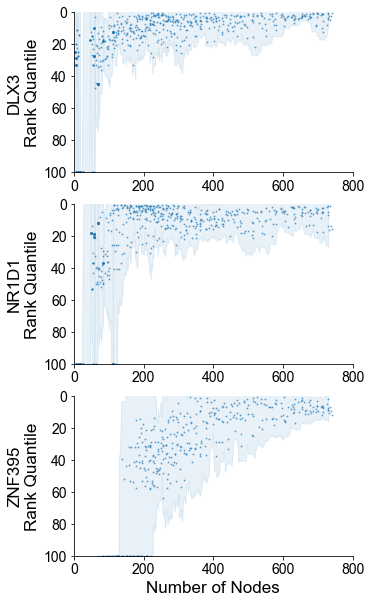

In [43]:
df = pd.read_csv(f'./../results/rank_gene_{treatments[2]}.txt', sep='\t')
var_x='nodes'
var_y = 'rank_betweenness'
fig = plt.figure(figsize=(5, 10))
genelist = gene_amp
for n, gene in enumerate(genelist):
    ax = fig.add_subplot(len(genelist),1,n+1)
    scatter_rank_for_gene(df, gene, var_x, var_y)
plt.xlabel('Number of Nodes', fontsize=17);
plt.savefig('./../figs/S4C1.svg', pad_inches=0.1, bbox_inches='tight')

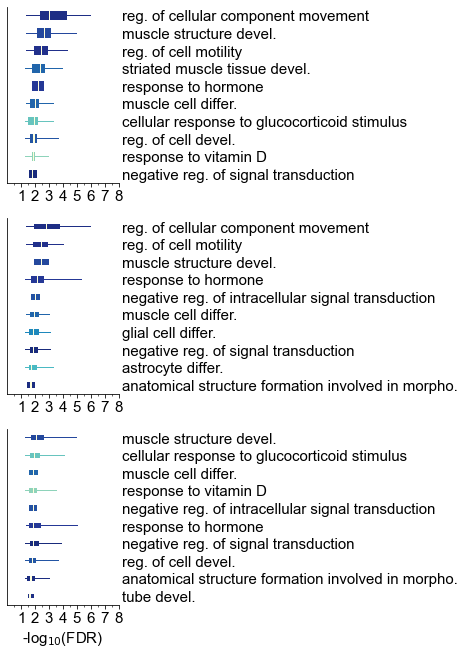

In [44]:
df_tfs = pd.read_csv(f'./../results/rank_community_{treatments[2]}.txt', sep='\t')
grn_number = len(df.drop_duplicates(subset=['run', 'nodes']))
fig = plt.figure(figsize=(2, 11))
for n, gene in enumerate(genelist):
    ax = fig.add_subplot(len(genelist),1,n+1)
    go_plot(gene_go_summary(df_tfs, go_files, treatments[2], gene), grn_number=grn_number, label_right=True)
plt.xlabel('-log'+r'$_{10}$'+'(FDR)');
plt.savefig('./../figs/S4C2.svg', pad_inches=0.1, bbox_inches='tight')

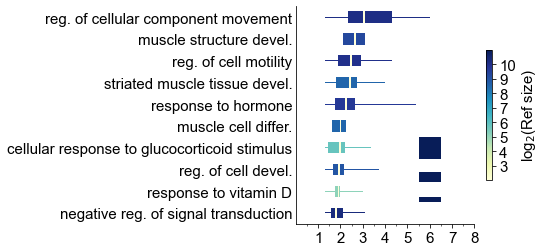

In [45]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1,1,1)
grns = len(df.drop_duplicates(subset=['run', 'nodes']))
go_plot(gene_go_summary(df_tfs, go_files, treatments[2], 'DLX3'), 
        grn_number=grns, count_legend=True, cbarn=True)
plt.savefig('./../figs/S4C3.svg', pad_inches=0.1, bbox_inches='tight')

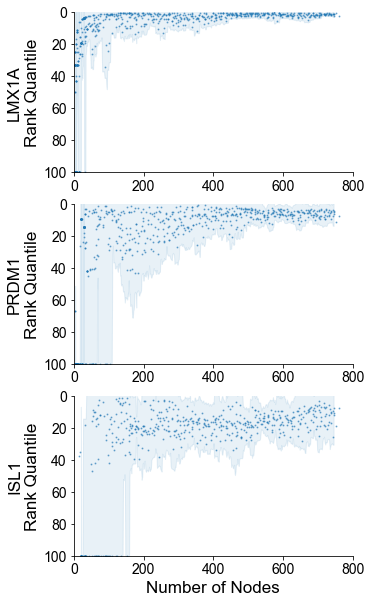

In [46]:
df = pd.read_csv(f'./../results/rank_gene_{treatments[3]}.txt', sep='\t')
var_x='nodes'
var_y = 'rank_betweenness'
fig = plt.figure(figsize=(5, 10))
genelist = gene_amnp
for n, gene in enumerate(genelist):
    ax = fig.add_subplot(len(genelist),1,n+1)
    scatter_rank_for_gene(df, gene, var_x, var_y)
plt.xlabel('Number of Nodes', fontsize=17);
plt.savefig('./../figs/S4D1.svg', pad_inches=0.1, bbox_inches='tight')

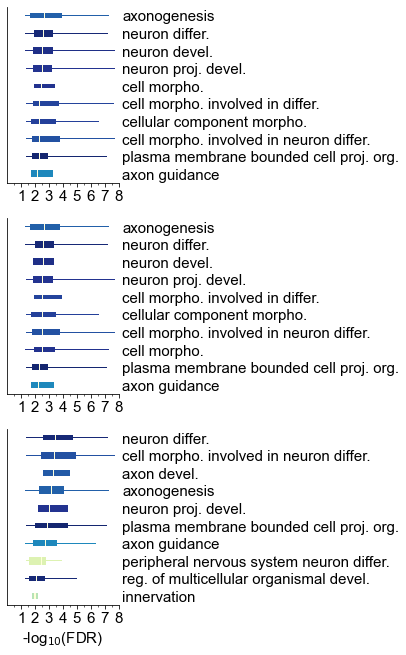

In [47]:
df_tfs = pd.read_csv(f'./../results/rank_community_{treatments[3]}.txt', sep='\t')
grn_number = len(df.drop_duplicates(subset=['run', 'nodes']))
fig = plt.figure(figsize=(2, 11))
for n, gene in enumerate(genelist):
    ax = fig.add_subplot(len(genelist),1,n+1)
    go_plot(gene_go_summary(df_tfs, go_files, treatments[3], gene), grn_number=grn_number, label_right=True)
plt.xlabel('-log'+r'$_{10}$'+'(FDR)');
plt.savefig('./../figs/S4D2.svg', pad_inches=0.1, bbox_inches='tight')

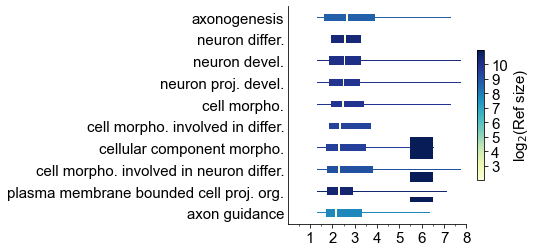

In [48]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1,1,1)
grns = len(df.drop_duplicates(subset=['run', 'nodes']))
go_plot(gene_go_summary(df_tfs, go_files, treatments[3], 'LMX1A'), 
        grn_number=grns, count_legend=True, cbarn=True)
plt.savefig('./../figs/S4D3.svg', pad_inches=0.1, bbox_inches='tight')